We have many products in our dataset. In this project, we will forecast the sales of any product for next day. 

productDailyActions.csv: 
You are expected to split this file into train and test dataset. It contains following informations for the dates between '2018-11-01' and '2019-01-12':
- productid: unique id for each product
- date: date of product action 
- soldquantity : sales of product
- stock : beginning stock count of product
- clickcount : # of clicks of product
- favoredcount: # of favored click of product


productAttributes.csv:
This file contains product related informations belonging to each product id. The file contains following informations: productid, gender, color, categoryid, brandid, subcategoryid, and price. 

**New Features:** We can create some new features using existing features

**Trends:** As we have only 72 days, it is unlikely that wwe can see the trends

Objectives:
We are asking you to build an algorithm(s) that can forecast the sales of any  product for next day. Please prepare the presentation with your results. In it, you’ll have to justify and explain:
- How did you create the target variable?
- How did you prepare the final dataset for modeling?
- How did you split datasets into training and testing?
- What methods did you use for modelling and why?
- How did you quantify the performance of your model(s)?


Target variable = **soldquantity**


In this project, we will use the products with 72 observations


Models = Ridge Regression, XGBoostRegressor, LSTM, LigthGBM


**Professor's Feedback**

Your project proposal looks interesting. Please describe your dataset in more detail. (how many, outlier, missing values and so on ). Since you are using time-series data, you need to varying the time window and discuss its impacts. In addition, you need to consider the computational complexity when you compare the ML algorithms.

# 1. Import Libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import lightgbm as lgb
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

# 2. Explanatory Data Analysis

In [27]:
# Read the attributes csv file
attributes = pd.read_csv('productAttributes.csv')
attributes

,productid,gender,color,categoryid,brandid,subcategoryid,price
0,81,2,4893,407,390,20,2114
1,121,1,1684,411,390,23,1851
2,141,2,5414,434,390,56,2236
3,161,2,3500,411,390,23,1851
4,181,2,6784,1825,390,68,1421
...,...,...,...,...,...,...,...
19354,199531,1,463,599,646,52,826
19355,199601,2,447,599,1228,52,726
19356,199621,2,7425,411,126,23,1100
19357,199671,2,451,599,1091,52,527


In [28]:
attributes.isnull().sum()

productid        0
gender           0
color            0
categoryid       0
brandid          0
subcategoryid    0
price            0
dtype: int64

In [29]:
# Find the number of categories, subcategories, color, and brand
print('The number of product is :',len(np.unique(attributes['productid'])))
print('The number of categories is :',len(np.unique(attributes['categoryid'])))
print('The number of subcategories is :',len(np.unique(attributes['subcategoryid'])))
print('The number of brands is :',len(np.unique(attributes['brandid'])))
print('The number of colors is :',len(np.unique(attributes['color'])))

The number of product is : 19359
The number of categories is : 101
The number of subcategories is : 103
The number of brands is : 868
The number of colors is : 2243


In [30]:
# Read the DailyActions data

DailyActions = pd.read_csv('productDailyActions.csv')
DailyActions

,productid,date,soldquantity,stock,clickcount,favoredcount
0,1,2018-11-23,0,140,82.0,NaN
1,21,2018-11-30,0,3,11.0,NaN
2,21,2018-12-27,0,2,2.0,NaN
3,21,2019-01-09,0,2,2.0,1.0
4,21,2018-12-18,0,2,5.0,NaN
...,...,...,...,...,...,...
858930,199991,2018-12-12,0,3,NaN,NaN
858931,199991,2018-12-26,0,0,NaN,NaN
858932,199991,2019-01-01,0,0,NaN,NaN
858933,199991,2019-01-03,0,0,NaN,NaN


In [31]:
# We need to look at total sales for each day to see if there is promotion effect

TotalSales = DailyActions.groupby(['date']).sum()
TotalSales['sales_clickcountratio'] =  TotalSales['soldquantity'] / TotalSales['clickcount']
TotalSales

,productid,soldquantity,stock,clickcount,favoredcount,sales_clickcountratio
date,,,,,,
2018-11-01,1019578511,3640,1015488,634523.0,11229.0,0.005737
2018-11-02,1029842936,3424,928991,594615.0,10894.0,0.005758
2018-11-03,1030459293,3060,954775,596020.0,10449.0,0.005134
2018-11-04,1045588232,3274,927613,631938.0,11059.0,0.005181
2018-11-05,1074981267,3445,940755,609989.0,10654.0,0.005648
...,...,...,...,...,...,...
2019-01-07,1256189166,2954,17677333,659409.0,20359.0,0.004480
2019-01-08,1236848508,3828,17626785,726205.0,22937.0,0.005271
2019-01-09,1229998672,3778,17648992,719326.0,22626.0,0.005252


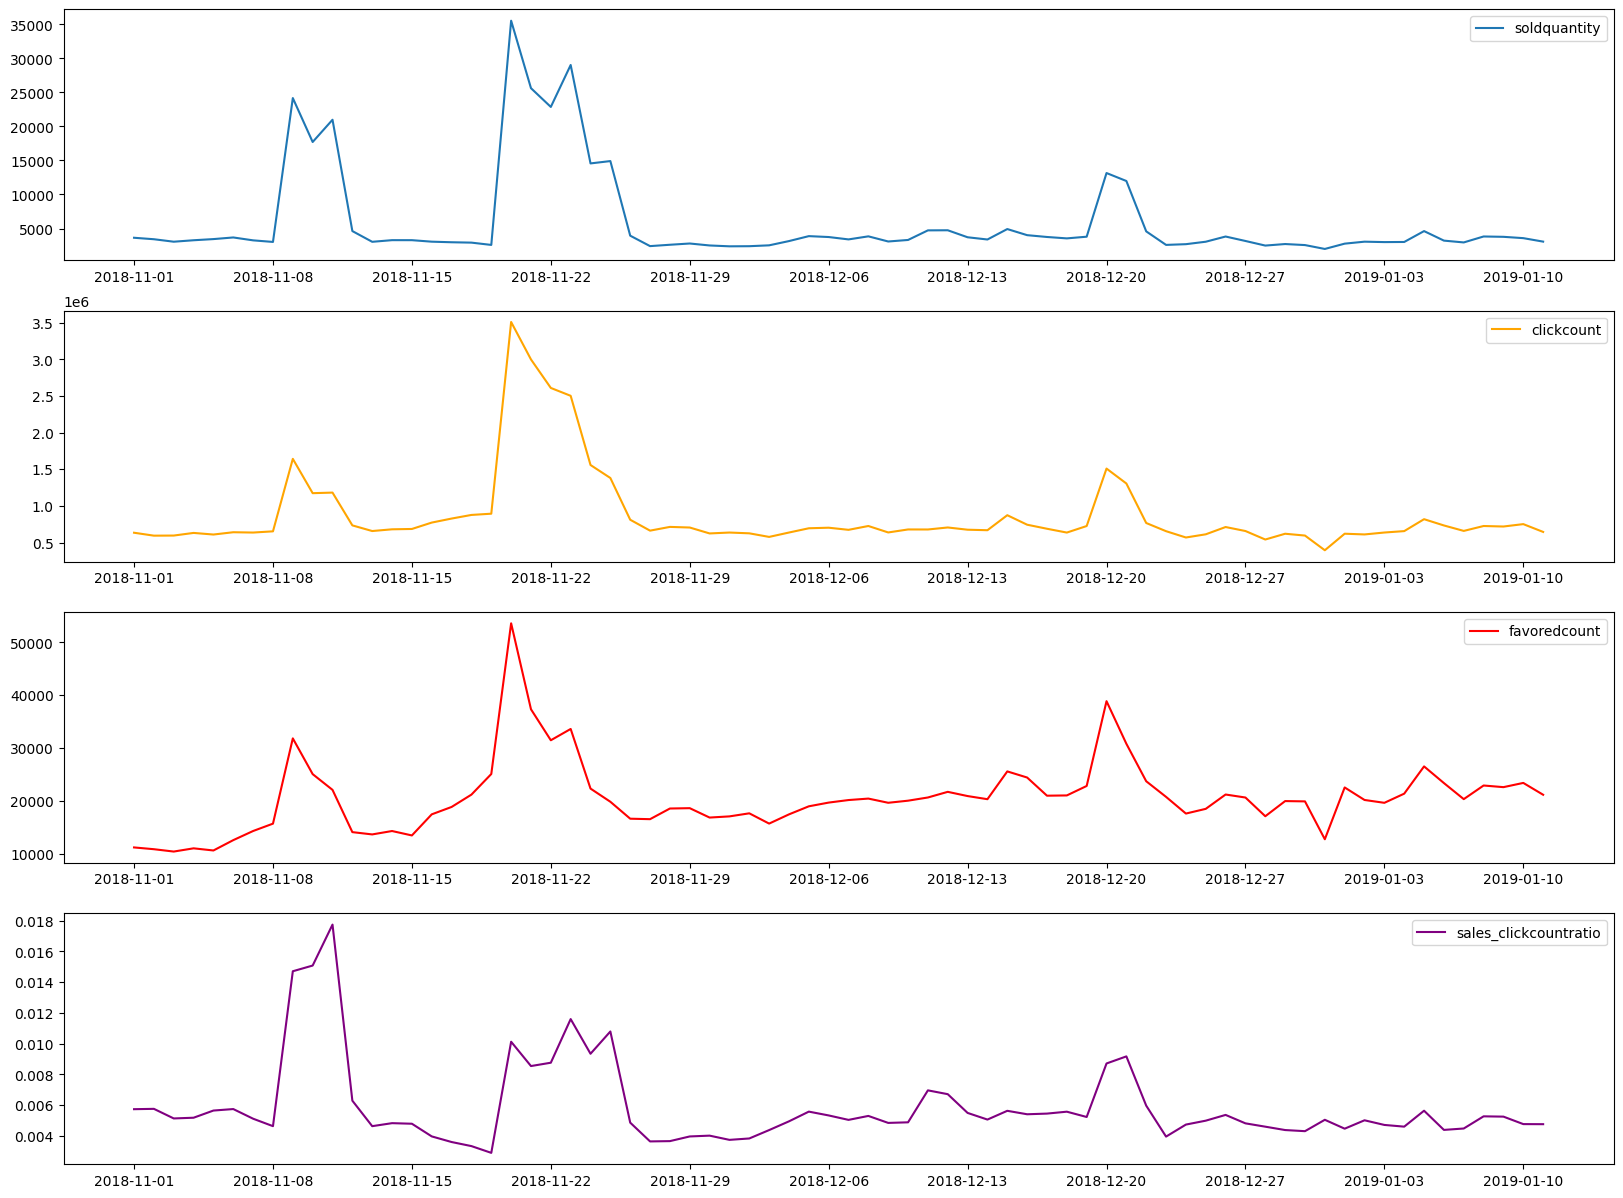

In [32]:
# Figures show that soldqunatity, favoredcount, clickcount reach their max on 20th November (Black Friday promotions)
# We  need to create a black friday flag for the model. We need to see all dates on the graph!!!! As seen, promotion effect 
# dissappear in couple days. We need to create a feature to measure this effect.
plt.figure(figsize=(20,15))
plt.subplot(4, 1, 1)
plt.xticks(np.arange(0, 100, step=7))
plt.plot(TotalSales.index,TotalSales['soldquantity'])
plt.legend(['soldquantity'])
plt.subplot(4, 1, 2)
plt.xticks(np.arange(0, 100, step=7))
plt.plot(TotalSales.index,TotalSales['clickcount'],color='orange')
plt.legend(['clickcount'])
plt.subplot(4, 1, 3)
plt.xticks(np.arange(0, 100, step=7))
plt.plot(TotalSales.index,TotalSales['favoredcount'],color='red')
plt.legend(['favoredcount'])
plt.subplot(4, 1, 4)
plt.xticks(np.arange(0, 100, step=7))
plt.plot(TotalSales.index,TotalSales['sales_clickcountratio'],color='purple')
plt.legend(['sales_clickcountratio'])
plt.show()

# 2-a) Outlier Analysis

Interquartile Range is:  1491.0


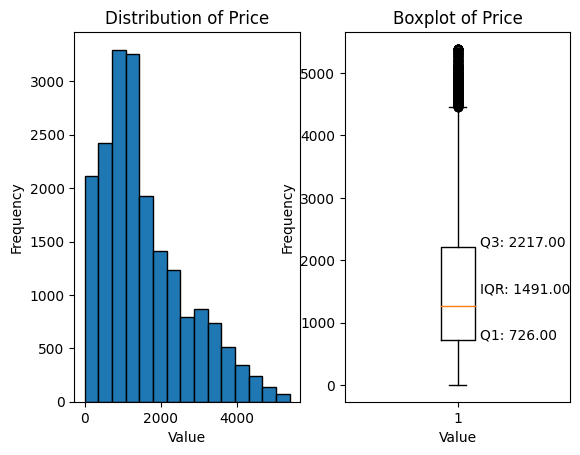

In [33]:
# We will take a look at the outliers in soldquantity (a product is rarely sold will be removed from the data) and in price
# We will use Interquartile Range method to remove outliers
# Let's start with price. In the attributes dataset, all productids are unique. As seen there are some outliers in the price
# Distribution of price is right-skewed

price =attributes['price']

# Take a loom the distribution of price
plt.subplot(1,2,1)
plt.hist(price,bins=15,edgecolor='black')
# add title and labels
plt.title("Distribution of Price")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Take a look at the box-plot of the price and find interquartile range

plt.subplot(1,2,2)

q1, q3 = np.percentile(price, [25, 75])
iqr = q3 - q1
print('Interquartile Range is: ', iqr)
# plot boxplot
plt.boxplot(price)

# add title and labels
plt.title("Boxplot of Price")
plt.xlabel("Value")
plt.ylabel("Frequency")

# add IQR label to plot
plt.text(1.1, q1, f'Q1: {q1:.2f}')
plt.text(1.1, q3, f'Q3: {q3:.2f}')
plt.text(1.1, q1+iqr/2, f'IQR: {iqr:.2f}')

# show the plot
plt.show()


In [34]:
# Find outlier using IQR. We need to remove products whose price greater than 4453.5

Below = q1 - 1.5*iqr
Above = q3 + 1.5*iqr

print('Prices below ' + str(Below) + ' are outliers')
print('Prices above ' + str(Above) + ' are outliers')

Prices below -1510.5 are outliers
Prices above 4453.5 are outliers


In [35]:
price_outliers = attributes[attributes['price']>4453.5]
print('The number of products with outlier price is: ', len(np.unique(price_outliers['productid'])))

The number of products with outlier price is:  334


In [36]:
# We removed 334 products from the data
attributes_no_outlier = attributes[attributes['price'] < 4453.5]
attributes_no_outlier

,productid,gender,color,categoryid,brandid,subcategoryid,price
0,81,2,4893,407,390,20,2114
1,121,1,1684,411,390,23,1851
2,141,2,5414,434,390,56,2236
3,161,2,3500,411,390,23,1851
4,181,2,6784,1825,390,68,1421
...,...,...,...,...,...,...,...
19354,199531,1,463,599,646,52,826
19355,199601,2,447,599,1228,52,726
19356,199621,2,7425,411,126,23,1100
19357,199671,2,451,599,1091,52,527


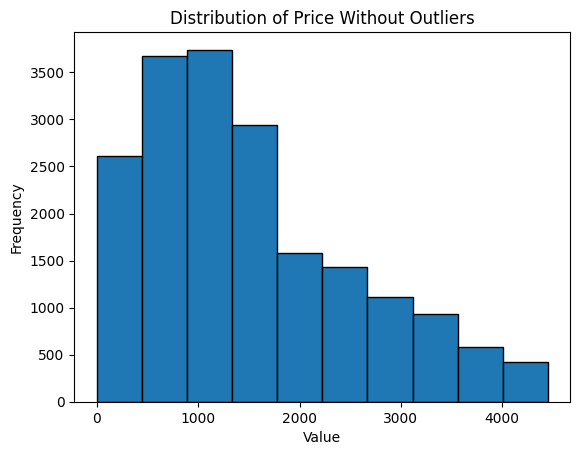

In [37]:
# Distribution without outliers. It looks better without outliers

non_outlier = attributes_no_outlier['price']
plt.hist(non_outlier,bins=10,edgecolor='black')
# add title and labels
plt.title("Distribution of Price Without Outliers")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [38]:
# Now, Let's take a look at the outliers in the soldqunatity. We need to find the total number of sales given time-period

TotalSales = DailyActions.groupby(['productid'])['soldquantity'].sum().to_frame().reset_index()
TotalSales

,productid,soldquantity
0,1,3
1,21,1
2,31,1
3,41,1
4,51,2
...,...,...
19354,199951,10
19355,199961,13
19356,199971,7
19357,199981,1


In [39]:
print('Min total sales is:', TotalSales['soldquantity'].min())
print('Max total sales is:', TotalSales['soldquantity'].max())

Min total sales is: 0
Max total sales is: 3729


Interquartile Range is:  14.0


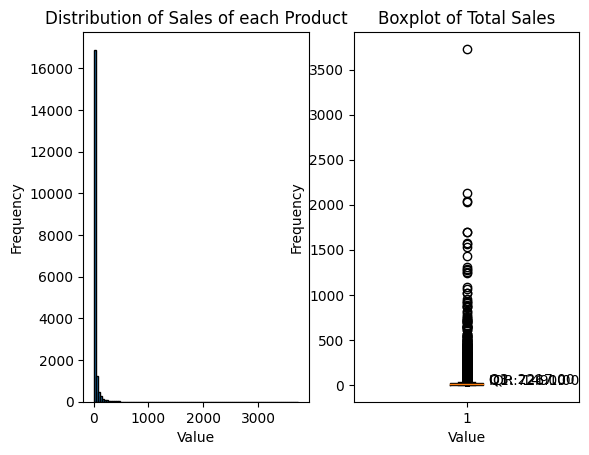

In [40]:
# Take a look at the distribution of the totalsales

totalsales = TotalSales['soldquantity']


# Take a look at the distribution of price
plt.subplot(1,2,1)
plt.hist(totalsales, bins=100,edgecolor='black')
# add title and labels
plt.title("Distribution of Sales of each Product")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1,2,2)

q1_sales, q3_sales = np.percentile(totalsales, [25, 75])
iqr_sales = q3_sales - q1_sales
print('Interquartile Range is: ', iqr_sales)
# plot boxplot
plt.boxplot(totalsales)

# add title and labels
plt.title("Boxplot of Total Sales")
plt.xlabel("Value")
plt.ylabel("Frequency")

# add IQR label to plot
plt.text(1.1, q1_sales, f'Q1: {q1:.2f}')
plt.text(1.1, q3_sales, f'Q3: {q3:.2f}')
plt.text(1.1, q1_sales+iqr_sales/2, f'IQR: {iqr:.2f}')


plt.show()

In [41]:
# Find outlier using IQR. We need to remove products whose price greater than 4453.5

Below = q1_sales - 1.5*iqr_sales
Above = q3_sales + 1.5*iqr_sales

print('Total Sales below ' + str(Below) + ' are outliers')
print('Total Sales above ' + str(Above) + ' are outliers')

Total Sales below -19.0 are outliers
Total Sales above 37.0 are outliers


In [42]:
sales_outliers = TotalSales[TotalSales['soldquantity']>37]
print('The number of products with total sales is greater than 37: ', len(np.unique(sales_outliers['productid'])))

The number of products with total sales is greater than 37:  2469


In [43]:
# We will remove the products are never sold during this time period instead of removing products sold greater 37.
# 915 products are never sold given time-period. We will remove these products

TotalSales[TotalSales['soldquantity']==0]

,productid,soldquantity
36,391,0
37,401,0
66,711,0
104,1101,0
130,1371,0
...,...,...
15685,163241,0
15687,163261,0
15707,163461,0
15753,163921,0


In [44]:
products_keep = TotalSales[TotalSales['soldquantity']>0]['productid'].to_frame().reset_index(drop=True)
DailyActions2 = products_keep.merge(DailyActions,on='productid',how='inner')
DailyActions2

,productid,date,soldquantity,stock,clickcount,favoredcount
0,1,2018-11-23,0,140,82.0,NaN
1,1,2018-11-26,1,138,23.0,NaN
2,1,2018-11-24,1,279,111.0,NaN
3,1,2018-11-25,1,139,60.0,NaN
4,21,2018-11-30,0,3,11.0,NaN
...,...,...,...,...,...,...
827958,199991,2018-12-12,0,3,NaN,NaN
827959,199991,2018-12-26,0,0,NaN,NaN
827960,199991,2019-01-01,0,0,NaN,NaN
827961,199991,2019-01-03,0,0,NaN,NaN


# 2-b) Missing Value Analysis

,percent_missing
productid,0.000000
date,0.000000
soldquantity,0.000000
stock,0.000000
clickcount,12.302241
favoredcount,63.882202


<AxesSubplot: >

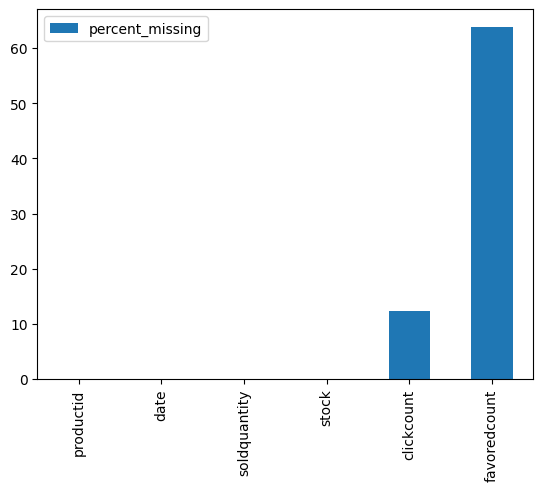

In [45]:
# Find the percentage of missing values. As seen 12% of clickcount is missing and 63% of favoredcount is missing
# These percenrages should be in presentation.
percent_missing = DailyActions2.isnull().sum() / len(DailyActions2) * 100
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df
display(missing_value_df)
barplot = missing_value_df.plot.bar()
barplot

,soldquantity
0,92.131501
1,5.511499
2,1.057656
3,0.401439
4,0.207802
...,...
141,0.000179
125,0.000179
235,0.000179
634,0.000179


<AxesSubplot: ylabel='soldquantity'>

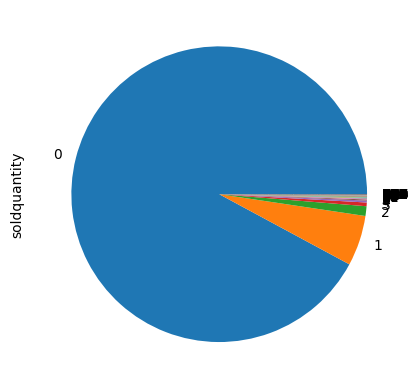

In [46]:
# Interesting! 92% of soldquantity is zero when the favored count is NaN. 
display(pd.DataFrame(DailyActions[DailyActions['favoredcount'].isnull()]['soldquantity'].value_counts(normalize=True)*100))
sold_NaN_fav = pd.DataFrame(DailyActions[DailyActions['favoredcount'].isnull()]['soldquantity'].value_counts(normalize=True)*100)
sold_NaN_fav.plot.pie(y = 'soldquantity', legend = None)

,soldquantity
0,99.815763
1,0.140989
2,0.012109
3,0.006055
4,0.004325
5,0.004325
12,0.001730
33,0.001730
9,0.001730
6,0.001730


<AxesSubplot: ylabel='soldquantity'>

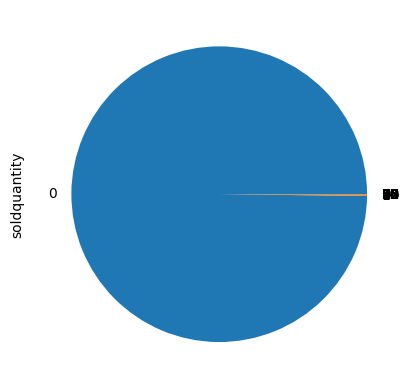

In [47]:
# Interesting! 99% of soldquantity is zero when the favored count is NaN. 
display(pd.DataFrame(DailyActions[DailyActions['clickcount'].isnull()]['soldquantity'].value_counts(normalize=True)*100))
soldNaNclick = pd.DataFrame(DailyActions[DailyActions['clickcount'].isnull()]['soldquantity'].value_counts(normalize=True)*100)
soldNaNclick.plot.pie(y = 'soldquantity', legend = None)

In [48]:
# Filling missing values with zero in favoredcount column

DailyActions2["favoredcount"] = DailyActions2["favoredcount"].fillna(0)

# Filling missing values in clickcount column. If soldquantity = 0 , then clickcount = 0. Otherwise, clickcount = soldquantity

DailyActions2['clickcount'] = DailyActions2.apply(lambda row: 0 if row['soldquantity'] == 0 else row['soldquantity'] if pd.isna(row['clickcount']) else row['clickcount'], axis=1)

In [49]:
# Now we have no missing values in our dataset
percent_missing = DailyActions2.isnull().sum() / len(DailyActions2) * 100
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

,percent_missing
productid,0.0
date,0.0
soldquantity,0.0
stock,0.0
clickcount,0.0
favoredcount,0.0


In [50]:
# Lets merge Dailyactions2 data and attributes data. As there are 101 categories and 103 subcategories in the dataset
# We will not use subcategoryid , categoryid, and brandid in the model so we will drop it.

df_merge = DailyActions2.merge(attributes_no_outlier,on='productid',how='inner')
df_merge = df_merge.drop(columns=['subcategoryid','categoryid','brandid'])
df_merge

,productid,date,soldquantity,stock,clickcount,favoredcount,gender,color,price
0,1,2018-11-23,0,140,0.0,0.0,1,1328,1996
1,1,2018-11-26,1,138,23.0,0.0,1,1328,1996
2,1,2018-11-24,1,279,111.0,0.0,1,1328,1996
3,1,2018-11-25,1,139,60.0,0.0,1,1328,1996
4,21,2018-11-30,0,3,0.0,0.0,2,1886,1100
...,...,...,...,...,...,...,...,...,...
812941,199991,2018-12-12,0,3,0.0,0.0,2,1528,83
812942,199991,2018-12-26,0,0,0.0,0.0,2,1528,83
812943,199991,2019-01-01,0,0,0.0,0.0,2,1528,83
812944,199991,2019-01-03,0,0,0.0,0.0,2,1528,83


In [51]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 812946 entries, 0 to 812945
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   productid     812946 non-null  int64  
 1   date          812946 non-null  object 
 2   soldquantity  812946 non-null  int64  
 3   stock         812946 non-null  int64  
 4   clickcount    812946 non-null  float64
 5   favoredcount  812946 non-null  float64
 6   gender        812946 non-null  int64  
 7   color         812946 non-null  int64  
 8   price         812946 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 62.0+ MB


In [52]:
df_merge.isnull().sum()

productid       0
date            0
soldquantity    0
stock           0
clickcount      0
favoredcount    0
gender          0
color           0
price           0
dtype: int64

In [54]:
# There are 18138 products in our final dataset after removing outliers
print('The number of products in the dataset after removing outliers:' ,len(np.unique(df_merge['productid'])))

The number of products in the dataset after removing outliers: 18138


# 3. Feature Engineering

In [55]:
# As there is November (promotion days) in given time period, we will add a promotion_day flag as a feature
# Creating promotion flag. 2018-11-09, 2018-11-10, 2018-11-11, 2018-11-20, 2018-11-21, 2018-11-22, 2018-11-23, 2018-11-24
# 2018-11-25, 2018-12-20, and 2018-12-21 are promotion days

df_merge['date'] = pd.to_datetime(df_merge['date'])

promotion_days = ['2018-11-09', '2018-11-10', '2018-11-11', '2018-11-20', '2018-11-21', '2018-11-22', '2018-11-23', '2018-11-24', '2018-11-25', '2018-12-20', '2018-12-21']
df_merge['promotion_day'] = df_merge['date'].apply(lambda x: 1 if str(x.date()) in promotion_days else 0)
df_merge

,productid,date,soldquantity,stock,clickcount,favoredcount,gender,color,price,promotion_day
0,1,2018-11-23,0,140,0.0,0.0,1,1328,1996,1
1,1,2018-11-26,1,138,23.0,0.0,1,1328,1996,0
2,1,2018-11-24,1,279,111.0,0.0,1,1328,1996,1
3,1,2018-11-25,1,139,60.0,0.0,1,1328,1996,1
4,21,2018-11-30,0,3,0.0,0.0,2,1886,1100,0
...,...,...,...,...,...,...,...,...,...,...
812941,199991,2018-12-12,0,3,0.0,0.0,2,1528,83,0
812942,199991,2018-12-26,0,0,0.0,0.0,2,1528,83,0
812943,199991,2019-01-01,0,0,0.0,0.0,2,1528,83,0
812944,199991,2019-01-03,0,0,0.0,0.0,2,1528,83,0


In [56]:
# Adding revenue feature and split the date into year,month, and day.
#df_merge=df_merge.set_index('date')
#df_merge['Month'] = df_merge.index.month
#df_merge['Day'] = df_merge.index.day
df_merge['revenue'] = df_merge['soldquantity'] * df_merge['price']
df_merge

,productid,date,soldquantity,stock,clickcount,favoredcount,gender,color,price,promotion_day,revenue
0,1,2018-11-23,0,140,0.0,0.0,1,1328,1996,1,0
1,1,2018-11-26,1,138,23.0,0.0,1,1328,1996,0,1996
2,1,2018-11-24,1,279,111.0,0.0,1,1328,1996,1,1996
3,1,2018-11-25,1,139,60.0,0.0,1,1328,1996,1,1996
4,21,2018-11-30,0,3,0.0,0.0,2,1886,1100,0,0
...,...,...,...,...,...,...,...,...,...,...,...
812941,199991,2018-12-12,0,3,0.0,0.0,2,1528,83,0,0
812942,199991,2018-12-26,0,0,0.0,0.0,2,1528,83,0,0
812943,199991,2019-01-01,0,0,0.0,0.0,2,1528,83,0,0
812944,199991,2019-01-03,0,0,0.0,0.0,2,1528,83,0,0


In [57]:
# Label encoding. There are some categorical features in the dataset. These features are gender, color, categoryid, brandid.
# Min-Max Scaler , we will scale the price and revenue features

df_merge2 = pd.get_dummies(df_merge,columns=['gender'],drop_first=True)
df_merge2


,productid,date,soldquantity,stock,clickcount,favoredcount,color,price,promotion_day,revenue,gender_2,gender_3
0,1,2018-11-23,0,140,0.0,0.0,1328,1996,1,0,0,0
1,1,2018-11-26,1,138,23.0,0.0,1328,1996,0,1996,0,0
2,1,2018-11-24,1,279,111.0,0.0,1328,1996,1,1996,0,0
3,1,2018-11-25,1,139,60.0,0.0,1328,1996,1,1996,0,0
4,21,2018-11-30,0,3,0.0,0.0,1886,1100,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
812941,199991,2018-12-12,0,3,0.0,0.0,1528,83,0,0,1,0
812942,199991,2018-12-26,0,0,0.0,0.0,1528,83,0,0,1,0
812943,199991,2019-01-01,0,0,0.0,0.0,1528,83,0,0,1,0
812944,199991,2019-01-03,0,0,0.0,0.0,1528,83,0,0,1,0


In [58]:
# Min-Max Scaler , we will scale the price and revenue features
#cols_to_scale = ['price', 'revenue']
#scaler = MinMaxScaler()
#df_merge2[cols_to_scale] = scaler.fit_transform(df_merge2[cols_to_scale])
#df_merge2= df_merge2.reset_index()
df_merge2

,productid,date,soldquantity,stock,clickcount,favoredcount,color,price,promotion_day,revenue,gender_2,gender_3
0,1,2018-11-23,0,140,0.0,0.0,1328,1996,1,0,0,0
1,1,2018-11-26,1,138,23.0,0.0,1328,1996,0,1996,0,0
2,1,2018-11-24,1,279,111.0,0.0,1328,1996,1,1996,0,0
3,1,2018-11-25,1,139,60.0,0.0,1328,1996,1,1996,0,0
4,21,2018-11-30,0,3,0.0,0.0,1886,1100,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
812941,199991,2018-12-12,0,3,0.0,0.0,1528,83,0,0,1,0
812942,199991,2018-12-26,0,0,0.0,0.0,1528,83,0,0,1,0
812943,199991,2019-01-01,0,0,0.0,0.0,1528,83,0,0,1,0
812944,199991,2019-01-03,0,0,0.0,0.0,1528,83,0,0,1,0


In [59]:
df_merge3 = df_merge2.copy()
df_merge3 = df_merge3.set_index('productid')
df_merge3

,date,soldquantity,stock,clickcount,favoredcount,color,price,promotion_day,revenue,gender_2,gender_3
productid,,,,,,,,,,,
1,2018-11-23,0,140,0.0,0.0,1328,1996,1,0,0,0
1,2018-11-26,1,138,23.0,0.0,1328,1996,0,1996,0,0
1,2018-11-24,1,279,111.0,0.0,1328,1996,1,1996,0,0
1,2018-11-25,1,139,60.0,0.0,1328,1996,1,1996,0,0
21,2018-11-30,0,3,0.0,0.0,1886,1100,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
199991,2018-12-12,0,3,0.0,0.0,1528,83,0,0,1,0
199991,2018-12-26,0,0,0.0,0.0,1528,83,0,0,1,0
199991,2019-01-01,0,0,0.0,0.0,1528,83,0,0,1,0


In [60]:
df_merge4 = df_merge3.copy()
df_merge4.sort_values(by=['productid','date'],inplace=True)
df_merge4

,date,soldquantity,stock,clickcount,favoredcount,color,price,promotion_day,revenue,gender_2,gender_3
productid,,,,,,,,,,,
1,2018-11-23,0,140,0.0,0.0,1328,1996,1,0,0,0
1,2018-11-24,1,279,111.0,0.0,1328,1996,1,1996,0,0
1,2018-11-25,1,139,60.0,0.0,1328,1996,1,1996,0,0
1,2018-11-26,1,138,23.0,0.0,1328,1996,0,1996,0,0
21,2018-11-01,0,4,0.0,0.0,1886,1100,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
199991,2019-01-06,0,0,0.0,0.0,1528,83,0,0,1,0
199991,2019-01-07,0,0,0.0,0.0,1528,83,0,0,1,0
199991,2019-01-08,0,0,0.0,0.0,1528,83,0,0,1,0


In [61]:
def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['soldquantity_lag_' + str(lag)] = dataframe.groupby(['productid'])['soldquantity'].transform(
            lambda x: x.shift(lag)) 
    return dataframe

In [62]:
df_merge5 = lag_features(df_merge4, [1,3])

In [63]:
df_merge5

,date,soldquantity,stock,clickcount,favoredcount,color,price,promotion_day,revenue,gender_2,gender_3,soldquantity_lag_1,soldquantity_lag_3
productid,,,,,,,,,,,,,
1,2018-11-23,0,140,0.0,0.0,1328,1996,1,0,0,0,NaN,NaN
1,2018-11-24,1,279,111.0,0.0,1328,1996,1,1996,0,0,0.0,NaN
1,2018-11-25,1,139,60.0,0.0,1328,1996,1,1996,0,0,1.0,NaN
1,2018-11-26,1,138,23.0,0.0,1328,1996,0,1996,0,0,1.0,0.0
21,2018-11-01,0,4,0.0,0.0,1886,1100,0,0,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199991,2019-01-06,0,0,0.0,0.0,1528,83,0,0,1,0,0.0,0.0
199991,2019-01-07,0,0,0.0,0.0,1528,83,0,0,1,0,0.0,0.0
199991,2019-01-08,0,0,0.0,0.0,1528,83,0,0,1,0,0.0,0.0


In [64]:
df_merge5 = df_merge5.reset_index()
df_merge5

,productid,date,soldquantity,stock,clickcount,favoredcount,color,price,promotion_day,revenue,gender_2,gender_3,soldquantity_lag_1,soldquantity_lag_3
0,1,2018-11-23,0,140,0.0,0.0,1328,1996,1,0,0,0,NaN,NaN
1,1,2018-11-24,1,279,111.0,0.0,1328,1996,1,1996,0,0,0.0,NaN
2,1,2018-11-25,1,139,60.0,0.0,1328,1996,1,1996,0,0,1.0,NaN
3,1,2018-11-26,1,138,23.0,0.0,1328,1996,0,1996,0,0,1.0,0.0
4,21,2018-11-01,0,4,0.0,0.0,1886,1100,0,0,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812941,199991,2019-01-06,0,0,0.0,0.0,1528,83,0,0,1,0,0.0,0.0
812942,199991,2019-01-07,0,0,0.0,0.0,1528,83,0,0,1,0,0.0,0.0
812943,199991,2019-01-08,0,0,0.0,0.0,1528,83,0,0,1,0,0.0,0.0
812944,199991,2019-01-09,0,0,0.0,0.0,1528,83,0,0,1,0,0.0,0.0


# 4. Train and Test Splits

In [65]:
df1 = pd.DataFrame(np.unique(df_merge5['productid']),columns=['productid'])
train , test = train_test_split(df1,test_size= 0.2, random_state=42)
print("The number of products in training dataset is: ", len(np.unique(train['productid'])))
print("The number of products in test dataset is: ", len(np.unique(test['productid'])))

The number of products in training dataset is:  14510
The number of products in test dataset is:  3628


In [66]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [67]:
# There is no common products in train and test dataset
control_df = train.merge(test,on='productid',how='inner')
control_df

,productid


In [68]:
train = train.merge(df_merge5,on='productid',how='inner')
test = test.merge(df_merge5,on='productid',how='inner')
print("The number of products in training dataset is: ", len(np.unique(train['productid'])))
print("The number of products in test dataset is: ", len(np.unique(test['productid'])))

The number of products in training dataset is:  14510
The number of products in test dataset is:  3628


In [69]:
train

,productid,date,soldquantity,stock,clickcount,favoredcount,color,price,promotion_day,revenue,gender_2,gender_3,soldquantity_lag_1,soldquantity_lag_3
0,121581,2018-11-20,1,1,30.0,0.0,443,3922,1,3922,1,0,NaN,NaN
1,121581,2018-11-21,0,0,0.0,0.0,443,3922,1,0,1,0,1.0,NaN
2,121581,2018-11-22,0,0,0.0,0.0,443,3922,1,0,1,0,0.0,NaN
3,121581,2018-11-23,0,0,0.0,0.0,443,3922,1,0,1,0,0.0,1.0
4,121581,2018-11-24,0,0,0.0,0.0,443,3922,1,0,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648029,176061,2019-01-01,0,1,0.0,0.0,1724,1716,0,0,1,0,0.0,0.0
648030,176061,2019-01-02,0,1,0.0,0.0,1724,1716,0,0,1,0,0.0,0.0
648031,176061,2019-01-05,0,2,0.0,0.0,1724,1716,0,0,1,0,0.0,0.0
648032,176061,2019-01-06,0,2,0.0,0.0,1724,1716,0,0,1,0,0.0,0.0


In [70]:
test

,productid,date,soldquantity,stock,clickcount,favoredcount,color,price,promotion_day,revenue,gender_2,gender_3,soldquantity_lag_1,soldquantity_lag_3
0,117511,2018-11-01,0,37,0.0,0.0,436,1721,0,0,1,0,NaN,NaN
1,117511,2018-11-02,0,74,0.0,0.0,436,1721,0,0,1,0,0.0,NaN
2,117511,2018-11-03,0,37,0.0,0.0,436,1721,0,0,1,0,0.0,NaN
3,117511,2018-11-04,0,37,0.0,0.0,436,1721,0,0,1,0,0.0,0.0
4,117511,2018-11-05,0,74,0.0,1.0,436,1721,0,0,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164907,174521,2019-01-04,0,1,0.0,1.0,5614,1840,0,0,0,0,0.0,0.0
164908,174521,2019-01-05,0,1,0.0,1.0,5614,1840,0,0,0,0,0.0,0.0
164909,174521,2019-01-06,0,2,0.0,1.0,5614,1840,0,0,0,0,0.0,0.0
164910,174521,2019-01-07,1,1,24.0,0.0,5614,1840,0,1840,0,0,0.0,0.0


In [71]:
print('Shape of the train dataset: ', train.shape)
print('Shape of the test dataset: ', test.shape)

Shape of the train dataset:  (648034, 14)
Shape of the test dataset:  (164912, 14)


In [72]:
print('Minimum date in the train:', train.date.min())
print('Maximum date in the train:', train.date.max())
print('Minimum date in the test:', test.date.min())
print('Maximum date in the test:', test.date.max())

Minimum date in the train: 2018-11-01 00:00:00
Maximum date in the train: 2019-01-11 00:00:00
Minimum date in the test: 2018-11-01 00:00:00
Maximum date in the test: 2019-01-11 00:00:00


In [73]:
# soldquantity(target variable), and date won't be used as a feature so they are dropped. We had to drop color due to the memory error
cols = [col for col in train.columns if col not in ['color']]
cols2 = cols[3:]

In [74]:
cols2

['stock',
 'clickcount',
 'favoredcount',
 'price',
 'promotion_day',
 'revenue',
 'gender_2',
 'gender_3',
 'soldquantity_lag_1',
 'soldquantity_lag_3']

In [75]:
y_train = train['soldquantity']
X_train = train[cols]

y_test = test['soldquantity']
X_test = test[cols]

In [76]:
X_train

,productid,date,soldquantity,stock,clickcount,favoredcount,price,promotion_day,revenue,gender_2,gender_3,soldquantity_lag_1,soldquantity_lag_3
0,121581,2018-11-20,1,1,30.0,0.0,3922,1,3922,1,0,NaN,NaN
1,121581,2018-11-21,0,0,0.0,0.0,3922,1,0,1,0,1.0,NaN
2,121581,2018-11-22,0,0,0.0,0.0,3922,1,0,1,0,0.0,NaN
3,121581,2018-11-23,0,0,0.0,0.0,3922,1,0,1,0,0.0,1.0
4,121581,2018-11-24,0,0,0.0,0.0,3922,1,0,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
648029,176061,2019-01-01,0,1,0.0,0.0,1716,0,0,1,0,0.0,0.0
648030,176061,2019-01-02,0,1,0.0,0.0,1716,0,0,1,0,0.0,0.0
648031,176061,2019-01-05,0,2,0.0,0.0,1716,0,0,1,0,0.0,0.0
648032,176061,2019-01-06,0,2,0.0,0.0,1716,0,0,1,0,0.0,0.0


In [77]:
X_train2 = X_train.drop(columns = ['productid','date','soldquantity'])
X_train2

,stock,clickcount,favoredcount,price,promotion_day,revenue,gender_2,gender_3,soldquantity_lag_1,soldquantity_lag_3
0,1,30.0,0.0,3922,1,3922,1,0,NaN,NaN
1,0,0.0,0.0,3922,1,0,1,0,1.0,NaN
2,0,0.0,0.0,3922,1,0,1,0,0.0,NaN
3,0,0.0,0.0,3922,1,0,1,0,0.0,1.0
4,0,0.0,0.0,3922,1,0,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
648029,1,0.0,0.0,1716,0,0,1,0,0.0,0.0
648030,1,0.0,0.0,1716,0,0,1,0,0.0,0.0
648031,2,0.0,0.0,1716,0,0,1,0,0.0,0.0
648032,2,0.0,0.0,1716,0,0,1,0,0.0,0.0


In [78]:
X_test

,productid,date,soldquantity,stock,clickcount,favoredcount,price,promotion_day,revenue,gender_2,gender_3,soldquantity_lag_1,soldquantity_lag_3
0,117511,2018-11-01,0,37,0.0,0.0,1721,0,0,1,0,NaN,NaN
1,117511,2018-11-02,0,74,0.0,0.0,1721,0,0,1,0,0.0,NaN
2,117511,2018-11-03,0,37,0.0,0.0,1721,0,0,1,0,0.0,NaN
3,117511,2018-11-04,0,37,0.0,0.0,1721,0,0,1,0,0.0,0.0
4,117511,2018-11-05,0,74,0.0,1.0,1721,0,0,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164907,174521,2019-01-04,0,1,0.0,1.0,1840,0,0,0,0,0.0,0.0
164908,174521,2019-01-05,0,1,0.0,1.0,1840,0,0,0,0,0.0,0.0
164909,174521,2019-01-06,0,2,0.0,1.0,1840,0,0,0,0,0.0,0.0
164910,174521,2019-01-07,1,1,24.0,0.0,1840,0,1840,0,0,0.0,0.0


In [79]:
X_test2 = X_test.drop(columns = ['productid','date','soldquantity'])
X_test2

,stock,clickcount,favoredcount,price,promotion_day,revenue,gender_2,gender_3,soldquantity_lag_1,soldquantity_lag_3
0,37,0.0,0.0,1721,0,0,1,0,NaN,NaN
1,74,0.0,0.0,1721,0,0,1,0,0.0,NaN
2,37,0.0,0.0,1721,0,0,1,0,0.0,NaN
3,37,0.0,0.0,1721,0,0,1,0,0.0,0.0
4,74,0.0,1.0,1721,0,0,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
164907,1,0.0,1.0,1840,0,0,0,0,0.0,0.0
164908,1,0.0,1.0,1840,0,0,0,0,0.0,0.0
164909,2,0.0,1.0,1840,0,0,0,0,0.0,0.0
164910,1,24.0,0.0,1840,0,1840,0,0,0.0,0.0


# 5. LightGBM Model

In [106]:
# Functions will be used

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val


def relu(x):
    return np.maximum(0, x)

In [689]:
# 5-fold cross validation

lgb_params = {'boosting_type': 'gbdt',
              'metric': 'mae',
              'objective': 'regression',
              'num_leaves': 12,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 10,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 100,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train2, label=y_train, feature_name=cols2)

cv_results = lgb.cv(lgb_params, lgbtrain, nfold=5,early_stopping_rounds=lgb_params['early_stopping_rounds'],
                    stratified = False,
                    shuffle=False,
                    verbose_eval=200)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

In [690]:
print('Mean MAPE:', cv_results['l1-mean'][-1])
print('Standard deviation:', cv_results['l1-stdv'][-1])

Mean MAPE: 0.047852803713254115
Standard deviation: 0.007098254609772872


In [662]:
lgb_params = {'boosting_type': 'gbdt',
              'metric': 'mae',
              'objective': 'regression',
              'num_leaves': 12,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 10,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 100,
              'nthread': -1}


# Training Model using same hyperparameters in cross validation
lgbtrain = lgb.Dataset(data=X_train2, label=y_train, feature_name=cols2)
lgbval = lgb.Dataset(data=X_test2, label=y_test, reference=lgbtrain, feature_name=cols2)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=200)

C:\Users\ufuks\miniconda3\envs\tf\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\ufuks\miniconda3\envs\tf\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ufuks\miniconda3\envs\tf\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[200]	training's l1: 0.140904	valid_1's l1: 0.13731
[400]	training's l1: 0.097742	valid_1's l1: 0.0950517
[600]	training's l1: 0.0913461	valid_1's l1: 0.0910374
[800]	training's l1: 0.0874623	valid_1's l1: 0.0896908
[1000]	training's l1: 0.0813856	valid_1's l1: 0.0853288
[1200]	training's l1: 0.0747981	valid_1's l1: 0.0800079
[1400]	training's l1: 0.0693929	valid_1's l1: 0.075441
[1600]	training's l1: 0.0660453	valid_1's l1: 0.072844
[1800]	training's l1: 0.0630774	valid_1's l1: 0.0705093
[2000]	training's l1: 0.0597266	valid_1's l1: 0.0676204
[2200]	training's l1: 0.0577268	valid_1's l1: 0.0660976
[2400]	training's l1: 0.0556604	valid_1's l1: 0.0643738
[2600]	training's l1: 0.054122	valid_1's l1: 0.

A mean absolute percentage error (MAPE) of 0.0115189 means that, on average, the model's predictions are off by **1.15189%** of the true value.

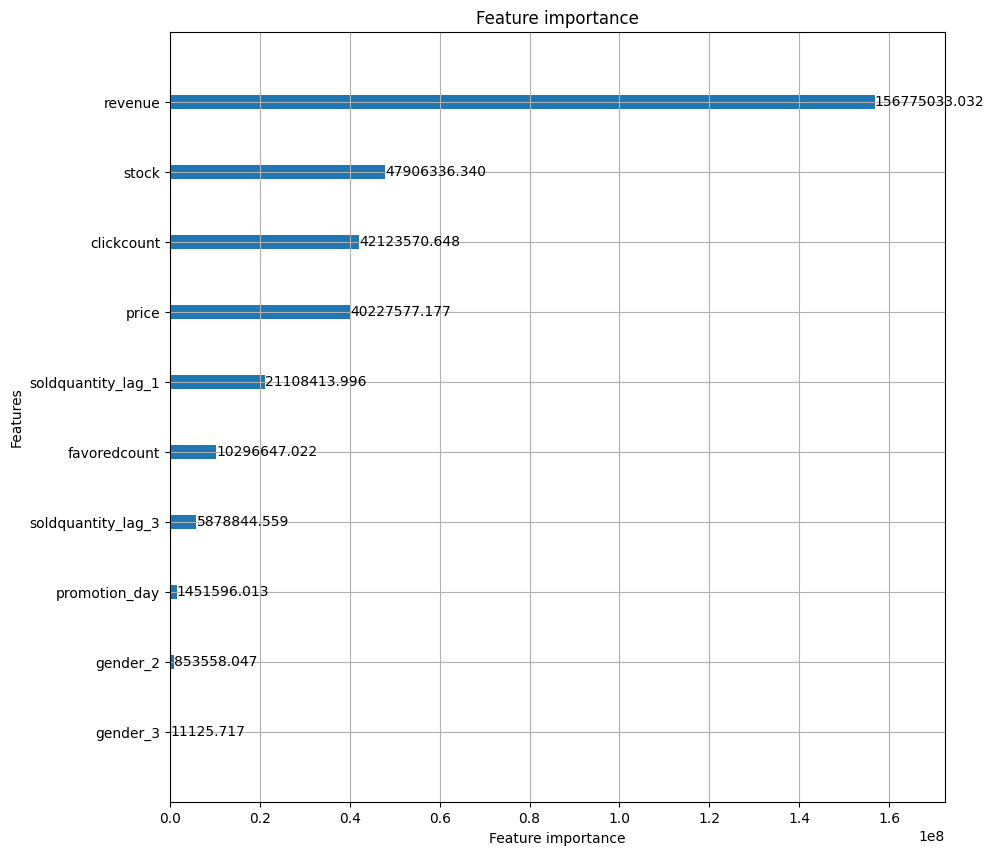

In [663]:
lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type ='gain')
plt.show()

In [665]:
# Predictions
y_pred = np.round(relu(model.predict(X_test2)))

In [716]:
# SMAPE error function
smape = smape(y_pred, y_test)
print("SMAPE: ", smape)

SMAPE:  0.21389978506176974


In [717]:
# Mean Absolute Error Function
mae = mean_absolute_error(y_test, y_pred)
print("MAE: ", mae)

MAE:  0.026383768312797127


# 6. Test some products

In [694]:
def predict_product_sales(productid):
    
    product = X_test[X_test['productid']==productid].sort_values('date')
    features = product.iloc[:,3:]
    product_sales_pred = np.round(relu(model.predict(features)))
    product_actual = product.iloc[:,0:3]
    product_actual['prediction'] = product_sales_pred
    product_actual = product_actual
    print(product_actual)
    
    plt.figure(figsize=(7,7))
    plt.plot(product_actual['date'],product_actual['soldquantity'])
    plt.plot(product_actual['date'],product_actual['prediction'])
    plt.title('Product ' + str(productid))
    plt.legend(['sales','predicted_sales'])
    plt.show()

    productid       date  soldquantity  prediction
0      117511 2018-11-01             0         0.0
1      117511 2018-11-02             0         0.0
2      117511 2018-11-03             0         0.0
3      117511 2018-11-04             0         0.0
4      117511 2018-11-05             0         0.0
..        ...        ...           ...         ...
67     117511 2019-01-07             0         0.0
68     117511 2019-01-08             0         0.0
69     117511 2019-01-09             0         0.0
70     117511 2019-01-10             0         0.0
71     117511 2019-01-11             1         1.0

[72 rows x 4 columns]


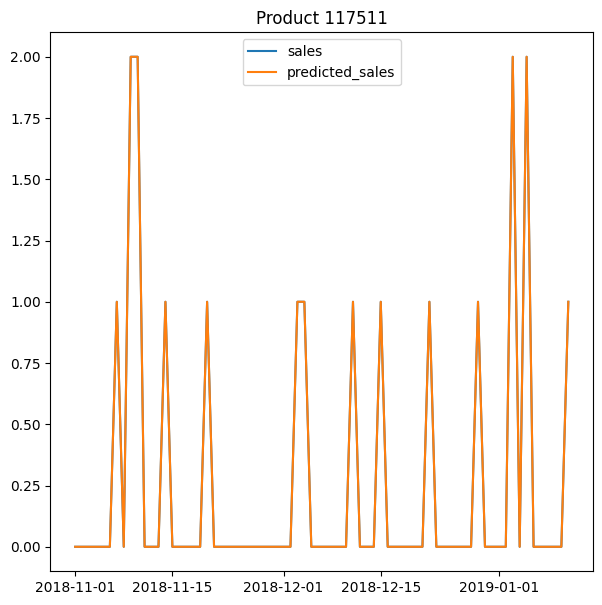

In [695]:
# If the prediction is less than 1 then we can assume that it is equal to zero
predict_product_sales(117511)

        productid       date  soldquantity  prediction
164892     174521 2018-11-20             1         1.0
164893     174521 2018-11-21             0         0.0
164894     174521 2018-11-22             0         0.0
164895     174521 2018-11-23             0         0.0
164896     174521 2018-11-24             0         0.0
164897     174521 2018-11-25             0         0.0
164898     174521 2018-11-26             0         0.0
164899     174521 2018-12-18             0         0.0
164900     174521 2018-12-19             0         0.0
164901     174521 2018-12-20             1         1.0
164902     174521 2018-12-21             0         0.0
164903     174521 2018-12-22             0         0.0
164904     174521 2019-01-01             0         0.0
164905     174521 2019-01-02             0         0.0
164906     174521 2019-01-03             0         0.0
164907     174521 2019-01-04             0         0.0
164908     174521 2019-01-05             0         0.0
164909    

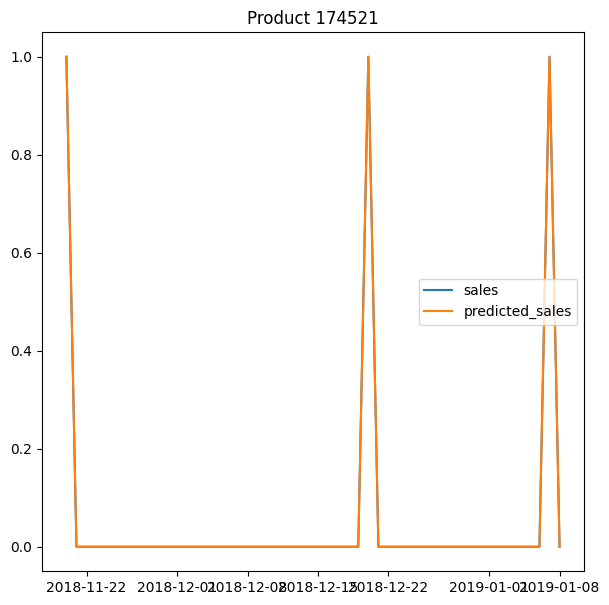

In [696]:
predict_product_sales(174521)

    productid       date  soldquantity  prediction
72     170591 2018-11-09             1         1.0
73     170591 2018-11-10             4         4.0
74     170591 2018-11-11            11        11.0
75     170591 2018-11-12             2         2.0
76     170591 2018-11-20            27        26.0
77     170591 2018-11-21            11        12.0
78     170591 2018-11-22             6         6.0
79     170591 2018-11-23            10         9.0
80     170591 2018-11-24             5         5.0
81     170591 2018-11-25             0         0.0
82     170591 2018-11-26             0         0.0
83     170591 2018-12-26            21        21.0
84     170591 2018-12-27             7         7.0


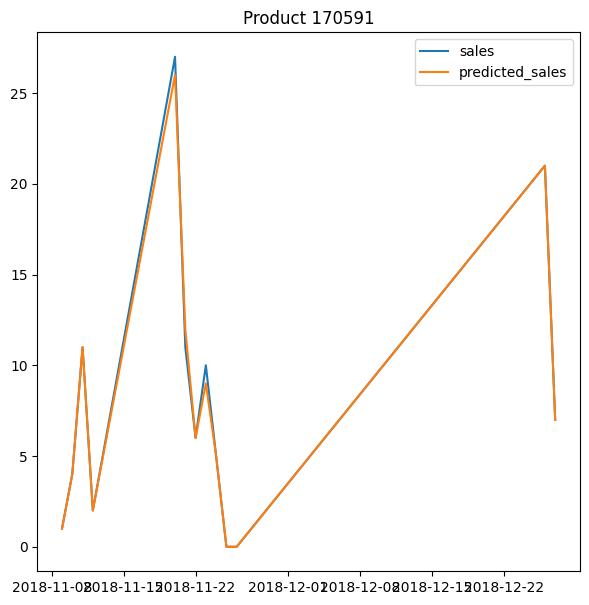

In [697]:
predict_product_sales(170591)

      productid       date  soldquantity  prediction
2703      48911 2018-11-01             0         0.0
2704      48911 2018-11-02             0         0.0
2705      48911 2018-11-03             1         1.0
2706      48911 2018-11-04             0         0.0
2707      48911 2018-11-05             0         0.0
...         ...        ...           ...         ...
2770      48911 2019-01-07             0         0.0
2771      48911 2019-01-08             0         0.0
2772      48911 2019-01-09             0         0.0
2773      48911 2019-01-10             0         0.0
2774      48911 2019-01-11             0         0.0

[72 rows x 4 columns]


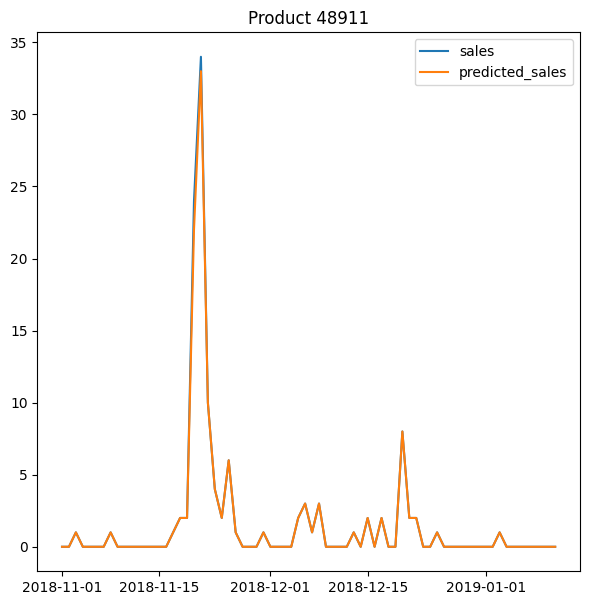

In [698]:
predict_product_sales(48911)

        productid       date  soldquantity  prediction
163910     132831 2018-11-05             1         1.0
163911     132831 2018-11-06             2         2.0
163912     132831 2018-11-07             0         0.0
163913     132831 2018-11-08             1         1.0
163914     132831 2018-11-09             4         4.0
163915     132831 2018-11-10             0         0.0
163916     132831 2018-11-11             0         0.0
163917     132831 2018-11-12             0         0.0
163918     132831 2018-11-21             2         2.0
163919     132831 2018-11-22             0         0.0
163920     132831 2018-11-23             0         0.0
163921     132831 2018-11-24             0         0.0
163922     132831 2018-11-25             0         0.0
163923     132831 2018-11-26             0         0.0
163924     132831 2018-12-03             1         1.0
163925     132831 2018-12-04             5         4.0
163926     132831 2018-12-05             0         0.0
163927    

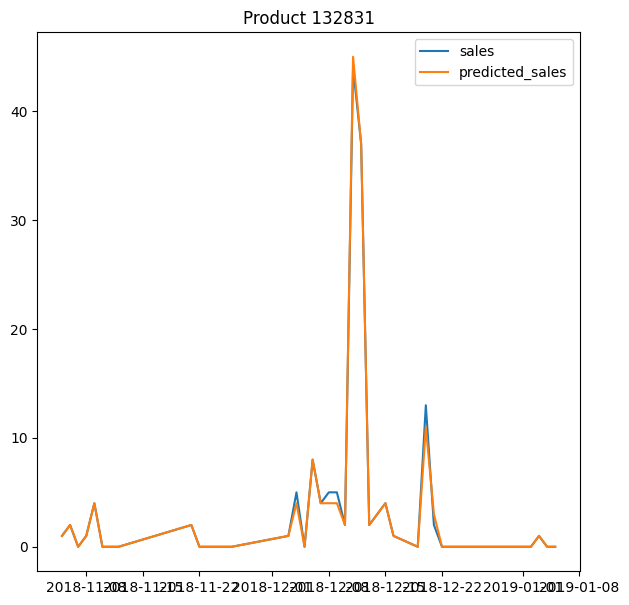

In [699]:
predict_product_sales(132831)

      productid       date  soldquantity  prediction
6059     143221 2018-11-01             0         0.0
6060     143221 2018-11-02             0         0.0
6061     143221 2018-11-03             3         3.0
6062     143221 2018-11-04             1         1.0
6063     143221 2018-11-05             1         1.0
...         ...        ...           ...         ...
6124     143221 2019-01-07             0         0.0
6125     143221 2019-01-08             0         0.0
6126     143221 2019-01-09             0         0.0
6127     143221 2019-01-10             0         0.0
6128     143221 2019-01-11             0         0.0

[70 rows x 4 columns]


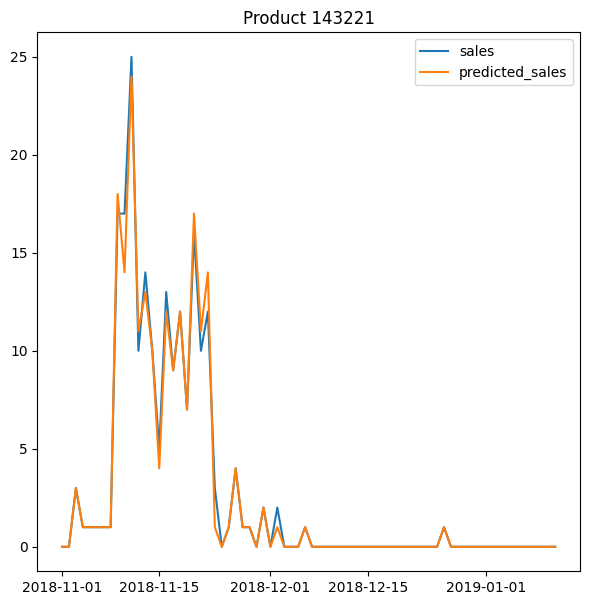

In [700]:
predict_product_sales(143221)

      productid       date  soldquantity  prediction
4794      57321 2018-11-01             0         0.0
4795      57321 2018-11-02             0         0.0
4796      57321 2018-11-03             1         1.0
4797      57321 2018-11-04             0         0.0
4798      57321 2018-11-05             0         0.0
...         ...        ...           ...         ...
4861      57321 2019-01-07             0         0.0
4862      57321 2019-01-08             0         0.0
4863      57321 2019-01-09             0         0.0
4864      57321 2019-01-10             0         0.0
4865      57321 2019-01-11             0         0.0

[72 rows x 4 columns]


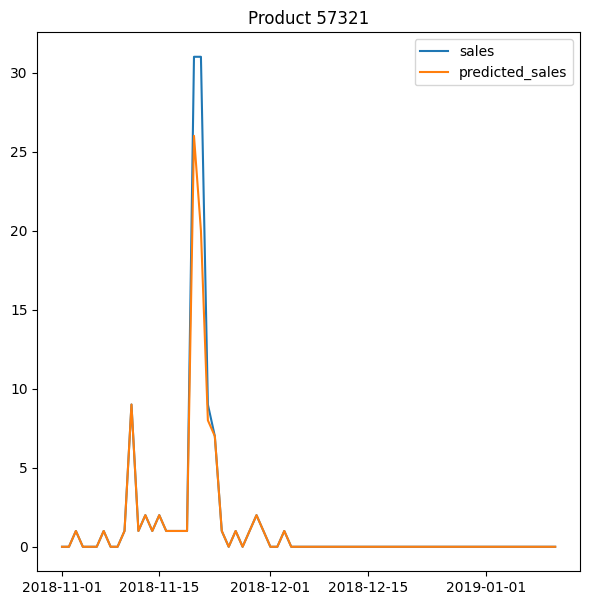

In [701]:
predict_product_sales(57321)

      productid       date  soldquantity  prediction
1232      39851 2018-11-09            20        20.0
1233      39851 2018-11-10             4         4.0
1234      39851 2018-11-11             3         3.0
1235      39851 2018-11-12             0         0.0
1236      39851 2018-12-01             0         0.0
1237      39851 2018-12-02             2         2.0
1238      39851 2018-12-03             1         1.0
1239      39851 2018-12-04             2         2.0
1240      39851 2018-12-05             4         4.0
1241      39851 2018-12-06             1         1.0
1242      39851 2018-12-07             5         5.0
1243      39851 2018-12-08             0         0.0
1244      39851 2018-12-09             0         0.0
1245      39851 2018-12-10             0         0.0
1246      39851 2018-12-11             0         0.0
1247      39851 2018-12-12             1         1.0
1248      39851 2018-12-13             0         0.0
1249      39851 2018-12-14             0      

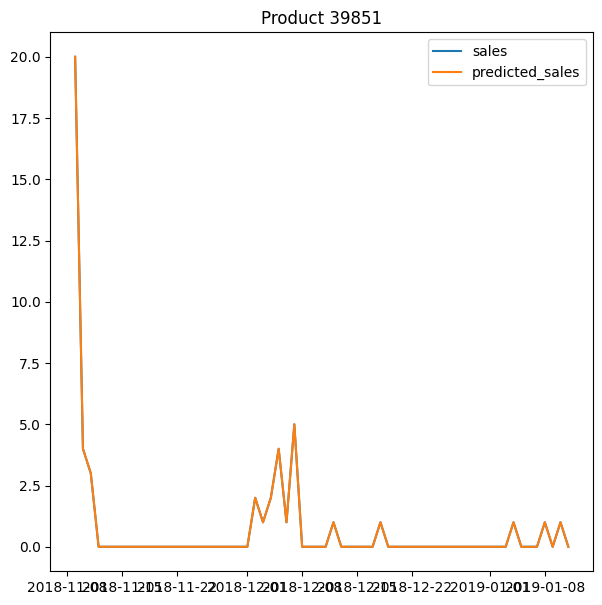

In [702]:
predict_product_sales(39851)

       productid       date  soldquantity  prediction
11333      30991 2018-11-01             0         0.0
11334      30991 2018-11-02             2         2.0
11335      30991 2018-11-03             0         0.0
11336      30991 2018-11-04             0         0.0
11337      30991 2018-11-05             0         0.0
...          ...        ...           ...         ...
11400      30991 2019-01-07             0         0.0
11401      30991 2019-01-08             0         0.0
11402      30991 2019-01-09             0         0.0
11403      30991 2019-01-10             1         1.0
11404      30991 2019-01-11             3         3.0

[72 rows x 4 columns]


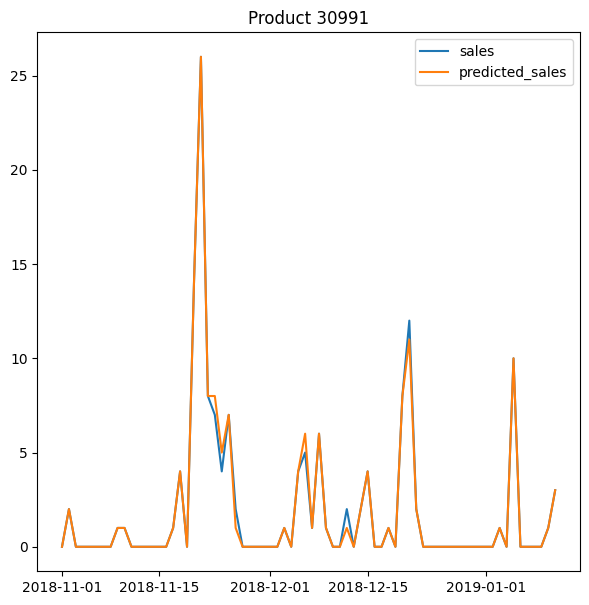

In [703]:
predict_product_sales(30991)

      productid       date  soldquantity  prediction
6749      77131 2018-11-01             2         0.0
6750      77131 2018-11-02             2         2.0
6751      77131 2018-11-03             0         0.0
6752      77131 2018-11-04             1         1.0
6753      77131 2018-11-05             5         5.0
...         ...        ...           ...         ...
6806      77131 2018-12-29             1         1.0
6807      77131 2018-12-30             0         0.0
6808      77131 2018-12-31             0         0.0
6809      77131 2019-01-01             0         0.0
6810      77131 2019-01-02             0         0.0

[62 rows x 4 columns]


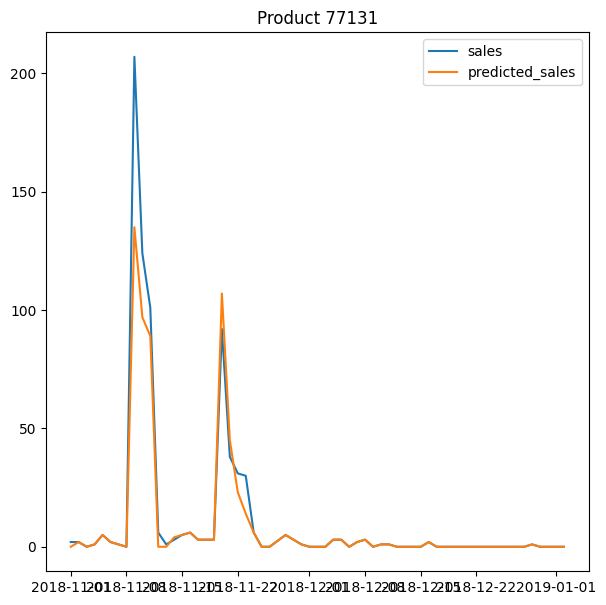

In [704]:
predict_product_sales(77131)

       productid       date  soldquantity  prediction
16340      23151 2018-11-23            17        18.0
16341      23151 2018-11-24            74        69.0
16342      23151 2018-11-25             0         2.0
16343      23151 2018-11-26             0         0.0
16344      23151 2018-12-11             2         5.0
16345      23151 2018-12-12             0         0.0
16346      23151 2018-12-13             0         0.0
16347      23151 2018-12-14             0         0.0
16348      23151 2018-12-15             0         0.0
16349      23151 2018-12-16             0         0.0
16350      23151 2018-12-30             5         5.0
16351      23151 2018-12-31             0         0.0
16352      23151 2019-01-01             0         0.0
16353      23151 2019-01-02             0         0.0
16354      23151 2019-01-03             0         0.0
16355      23151 2019-01-04             0         0.0
16356      23151 2019-01-05             0         0.0
16357      23151 2019-01-06 

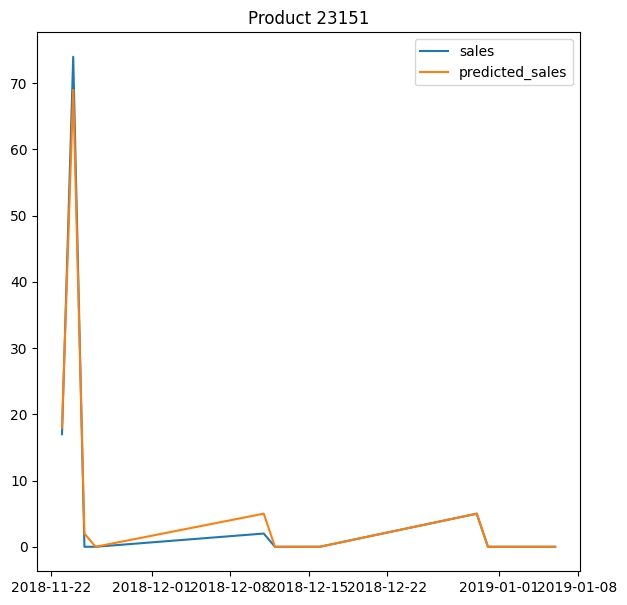

In [705]:
predict_product_sales(23151)

       productid       date  soldquantity  prediction
21432      25441 2018-11-01             9         9.0
21433      25441 2018-11-02             4         4.0
21434      25441 2018-11-03             2         2.0
21435      25441 2018-11-04             2         2.0
21436      25441 2018-11-05             5         5.0
...          ...        ...           ...         ...
21497      25441 2019-01-05             0         0.0
21498      25441 2019-01-06             0         0.0
21499      25441 2019-01-07             1         1.0
21500      25441 2019-01-08             0         0.0
21501      25441 2019-01-09             0         0.0

[70 rows x 4 columns]


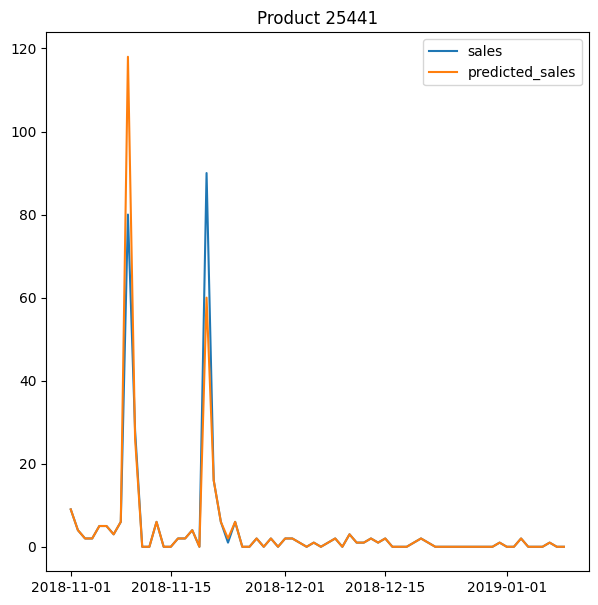

In [706]:
predict_product_sales(25441)

       productid       date  soldquantity  prediction
12477     180911 2018-11-19             0         0.0
12478     180911 2018-11-20             0         0.0
12479     180911 2018-11-21            61        74.0
12480     180911 2018-11-22            21        19.0
12481     180911 2018-11-23             8         8.0
12482     180911 2018-11-24             7         7.0
12483     180911 2018-11-25             0         0.0
12484     180911 2018-11-26             0         0.0
12485     180911 2018-11-28             3         3.0
12486     180911 2018-11-29             1         1.0
12487     180911 2018-11-30             0         0.0
12488     180911 2018-12-01             1         1.0
12489     180911 2018-12-02             0         0.0
12490     180911 2018-12-03             0         0.0
12491     180911 2018-12-05             0         0.0
12492     180911 2018-12-06             1         1.0
12493     180911 2018-12-07             0         0.0
12494     180911 2018-12-08 

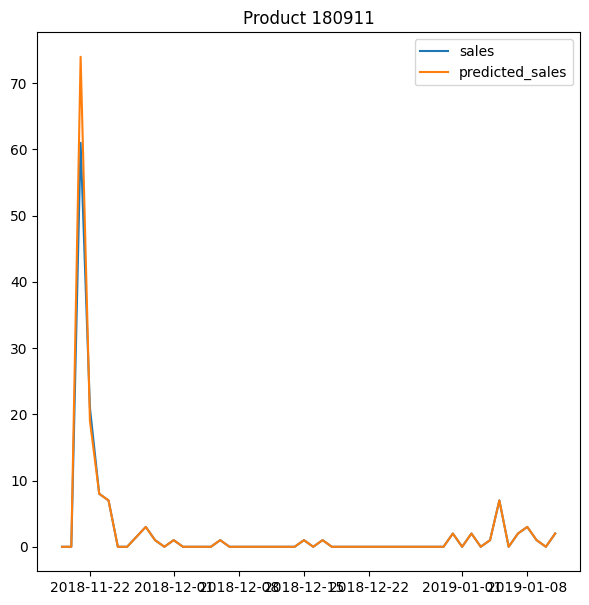

In [707]:
predict_product_sales(180911)

# 6. XGBRegressor

In [691]:
model2 = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

scores = cross_val_score(model2, X_train2, y_train, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -scores
print("MAE scores:", mae_scores)
print("Mean MAE:", np.mean(mae_scores))
print("Standard deviation:", np.std(mae_scores))

MAE scores: [0.03196666 0.02802157 0.02785687 0.02912256 0.02760402]
Mean MAE: 0.02891433504979629
Standard deviation: 0.0016119678892899303


In [692]:
model2 = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model2.fit(
    X_train2, 
    y_train, 
    eval_metric="mae", 
    eval_set=[(X_train2, y_train), (X_test2, y_test)], 
    verbose=True, 
    early_stopping_rounds = 20)

[0]	validation_0-mae:0.77688	validation_1-mae:0.74996


C:\Users\ufuks\miniconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ufuks\miniconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:0.70071	validation_1-mae:0.67474
[2]	validation_0-mae:0.63154	validation_1-mae:0.60807
[3]	validation_0-mae:0.56926	validation_1-mae:0.54775
[4]	validation_0-mae:0.51299	validation_1-mae:0.49329
[5]	validation_0-mae:0.46256	validation_1-mae:0.44475
[6]	validation_0-mae:0.41727	validation_1-mae:0.40136
[7]	validation_0-mae:0.37824	validation_1-mae:0.36328
[8]	validation_0-mae:0.34407	validation_1-mae:0.32997
[9]	validation_0-mae:0.31086	validation_1-mae:0.29816
[10]	validation_0-mae:0.28107	validation_1-mae:0.26982
[11]	validation_0-mae:0.25456	validation_1-mae:0.24467
[12]	validation_0-mae:0.23055	validation_1-mae:0.22200
[13]	validation_0-mae:0.20887	validation_1-mae:0.20148
[14]	validation_0-mae:0.18916	validation_1-mae:0.18296
[15]	validation_0-mae:0.17176	validation_1-mae:0.16674
[16]	validation_0-mae:0.15596	validation_1-mae:0.15260
[17]	validation_0-mae:0.14184	validation_1-mae:0.13968
[18]	validation_0-mae:0.13120	validation_1-mae:0.13040
[19]	validation_0-m

[150]	validation_0-mae:0.00988	validation_1-mae:0.02569
[151]	validation_0-mae:0.00986	validation_1-mae:0.02568
[152]	validation_0-mae:0.00968	validation_1-mae:0.02551
[153]	validation_0-mae:0.00962	validation_1-mae:0.02546
[154]	validation_0-mae:0.00956	validation_1-mae:0.02542
[155]	validation_0-mae:0.00954	validation_1-mae:0.02542
[156]	validation_0-mae:0.00950	validation_1-mae:0.02539
[157]	validation_0-mae:0.00949	validation_1-mae:0.02539
[158]	validation_0-mae:0.00941	validation_1-mae:0.02531
[159]	validation_0-mae:0.00939	validation_1-mae:0.02531
[160]	validation_0-mae:0.00936	validation_1-mae:0.02531
[161]	validation_0-mae:0.00935	validation_1-mae:0.02530
[162]	validation_0-mae:0.00931	validation_1-mae:0.02526
[163]	validation_0-mae:0.00926	validation_1-mae:0.02524
[164]	validation_0-mae:0.00923	validation_1-mae:0.02523
[165]	validation_0-mae:0.00923	validation_1-mae:0.02523
[166]	validation_0-mae:0.00922	validation_1-mae:0.02523
[167]	validation_0-mae:0.00918	validation_1-mae:

[297]	validation_0-mae:0.00541	validation_1-mae:0.02295
[298]	validation_0-mae:0.00540	validation_1-mae:0.02295
[299]	validation_0-mae:0.00540	validation_1-mae:0.02295
[300]	validation_0-mae:0.00537	validation_1-mae:0.02293
[301]	validation_0-mae:0.00535	validation_1-mae:0.02293
[302]	validation_0-mae:0.00535	validation_1-mae:0.02293
[303]	validation_0-mae:0.00533	validation_1-mae:0.02292
[304]	validation_0-mae:0.00530	validation_1-mae:0.02290
[305]	validation_0-mae:0.00526	validation_1-mae:0.02286
[306]	validation_0-mae:0.00521	validation_1-mae:0.02282
[307]	validation_0-mae:0.00521	validation_1-mae:0.02282
[308]	validation_0-mae:0.00520	validation_1-mae:0.02281
[309]	validation_0-mae:0.00518	validation_1-mae:0.02280
[310]	validation_0-mae:0.00516	validation_1-mae:0.02279
[311]	validation_0-mae:0.00513	validation_1-mae:0.02277
[312]	validation_0-mae:0.00512	validation_1-mae:0.02277
[313]	validation_0-mae:0.00511	validation_1-mae:0.02277
[314]	validation_0-mae:0.00510	validation_1-mae:

[444]	validation_0-mae:0.00353	validation_1-mae:0.02199
[445]	validation_0-mae:0.00352	validation_1-mae:0.02199
[446]	validation_0-mae:0.00352	validation_1-mae:0.02199
[447]	validation_0-mae:0.00351	validation_1-mae:0.02198
[448]	validation_0-mae:0.00350	validation_1-mae:0.02198
[449]	validation_0-mae:0.00347	validation_1-mae:0.02197
[450]	validation_0-mae:0.00346	validation_1-mae:0.02196
[451]	validation_0-mae:0.00346	validation_1-mae:0.02196
[452]	validation_0-mae:0.00345	validation_1-mae:0.02195
[453]	validation_0-mae:0.00344	validation_1-mae:0.02195
[454]	validation_0-mae:0.00343	validation_1-mae:0.02195
[455]	validation_0-mae:0.00340	validation_1-mae:0.02193
[456]	validation_0-mae:0.00340	validation_1-mae:0.02193
[457]	validation_0-mae:0.00339	validation_1-mae:0.02192
[458]	validation_0-mae:0.00338	validation_1-mae:0.02192
[459]	validation_0-mae:0.00338	validation_1-mae:0.02192
[460]	validation_0-mae:0.00336	validation_1-mae:0.02190
[461]	validation_0-mae:0.00335	validation_1-mae:

[591]	validation_0-mae:0.00248	validation_1-mae:0.02151
[592]	validation_0-mae:0.00247	validation_1-mae:0.02151
[593]	validation_0-mae:0.00247	validation_1-mae:0.02151
[594]	validation_0-mae:0.00246	validation_1-mae:0.02150
[595]	validation_0-mae:0.00246	validation_1-mae:0.02150
[596]	validation_0-mae:0.00245	validation_1-mae:0.02149
[597]	validation_0-mae:0.00244	validation_1-mae:0.02149
[598]	validation_0-mae:0.00244	validation_1-mae:0.02149
[599]	validation_0-mae:0.00243	validation_1-mae:0.02149
[600]	validation_0-mae:0.00243	validation_1-mae:0.02149
[601]	validation_0-mae:0.00243	validation_1-mae:0.02149
[602]	validation_0-mae:0.00242	validation_1-mae:0.02148
[603]	validation_0-mae:0.00241	validation_1-mae:0.02148
[604]	validation_0-mae:0.00241	validation_1-mae:0.02148
[605]	validation_0-mae:0.00241	validation_1-mae:0.02148
[606]	validation_0-mae:0.00240	validation_1-mae:0.02148
[607]	validation_0-mae:0.00240	validation_1-mae:0.02147
[608]	validation_0-mae:0.00239	validation_1-mae:

[738]	validation_0-mae:0.00185	validation_1-mae:0.02123
[739]	validation_0-mae:0.00185	validation_1-mae:0.02123
[740]	validation_0-mae:0.00185	validation_1-mae:0.02123
[741]	validation_0-mae:0.00185	validation_1-mae:0.02123
[742]	validation_0-mae:0.00184	validation_1-mae:0.02123
[743]	validation_0-mae:0.00184	validation_1-mae:0.02123
[744]	validation_0-mae:0.00184	validation_1-mae:0.02122
[745]	validation_0-mae:0.00183	validation_1-mae:0.02122
[746]	validation_0-mae:0.00183	validation_1-mae:0.02122
[747]	validation_0-mae:0.00182	validation_1-mae:0.02122
[748]	validation_0-mae:0.00182	validation_1-mae:0.02122
[749]	validation_0-mae:0.00181	validation_1-mae:0.02121
[750]	validation_0-mae:0.00181	validation_1-mae:0.02121
[751]	validation_0-mae:0.00181	validation_1-mae:0.02121
[752]	validation_0-mae:0.00180	validation_1-mae:0.02121
[753]	validation_0-mae:0.00180	validation_1-mae:0.02121
[754]	validation_0-mae:0.00179	validation_1-mae:0.02120
[755]	validation_0-mae:0.00179	validation_1-mae:

[885]	validation_0-mae:0.00142	validation_1-mae:0.02105
[886]	validation_0-mae:0.00142	validation_1-mae:0.02105
[887]	validation_0-mae:0.00141	validation_1-mae:0.02104
[888]	validation_0-mae:0.00141	validation_1-mae:0.02104
[889]	validation_0-mae:0.00141	validation_1-mae:0.02104
[890]	validation_0-mae:0.00141	validation_1-mae:0.02104
[891]	validation_0-mae:0.00140	validation_1-mae:0.02104
[892]	validation_0-mae:0.00140	validation_1-mae:0.02104
[893]	validation_0-mae:0.00140	validation_1-mae:0.02104
[894]	validation_0-mae:0.00140	validation_1-mae:0.02104
[895]	validation_0-mae:0.00140	validation_1-mae:0.02104
[896]	validation_0-mae:0.00140	validation_1-mae:0.02103
[897]	validation_0-mae:0.00139	validation_1-mae:0.02104
[898]	validation_0-mae:0.00139	validation_1-mae:0.02104
[899]	validation_0-mae:0.00139	validation_1-mae:0.02103
[900]	validation_0-mae:0.00139	validation_1-mae:0.02103
[901]	validation_0-mae:0.00139	validation_1-mae:0.02103
[902]	validation_0-mae:0.00139	validation_1-mae:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

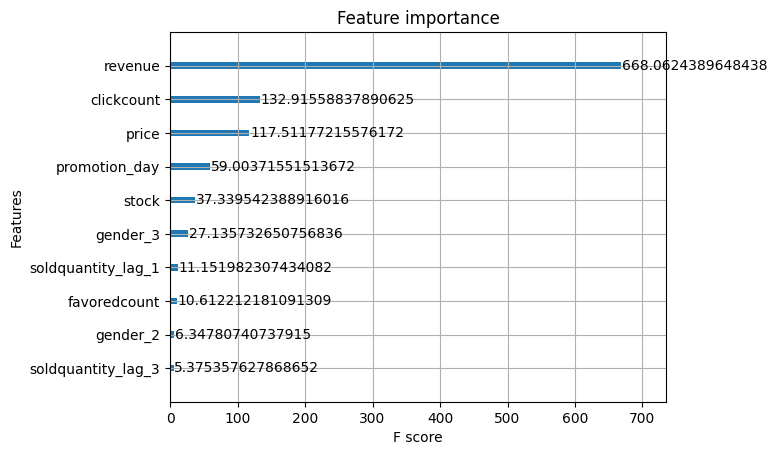

In [729]:
from xgboost import plot_importance
plot_importance(model2, importance_type='gain')
plt.show()

In [719]:
# Test error

# Predictions
y_pred2 = np.round(relu(model2.predict(X_test2)))

In [722]:
# SMAPE error function
smape = smape(y_pred2, y_test)
print("SMAPE: ", smape)

SMAPE:  0.07374918520478188


In [723]:
# Mean Absolute Error Function
mae = mean_absolute_error(y_test, y_pred)
print("MAE: ", mae)

MAE:  0.026383768312797127


In [724]:
def predict_product_sales_xgb(productid):
    
    product = X_test[X_test['productid']==productid].sort_values('date')
    features = product.iloc[:,3:]
    product_sales_pred = np.round(relu(model2.predict(features)))
    product_actual = product.iloc[:,0:3]
    product_actual['prediction'] = product_sales_pred
    product_actual = product_actual
    print(product_actual)
    
    plt.figure(figsize=(7,7))
    plt.plot(product_actual['date'],product_actual['soldquantity'])
    plt.plot(product_actual['date'],product_actual['prediction'])
    plt.title('Product ' + str(productid))
    plt.legend(['sales','predicted_sales'])
    plt.show()

      productid       date  soldquantity  prediction
2703      48911 2018-11-01             0         0.0
2704      48911 2018-11-02             0         0.0
2705      48911 2018-11-03             1         1.0
2706      48911 2018-11-04             0         0.0
2707      48911 2018-11-05             0         0.0
...         ...        ...           ...         ...
2770      48911 2019-01-07             0         0.0
2771      48911 2019-01-08             0         0.0
2772      48911 2019-01-09             0         0.0
2773      48911 2019-01-10             0         0.0
2774      48911 2019-01-11             0         0.0

[72 rows x 4 columns]


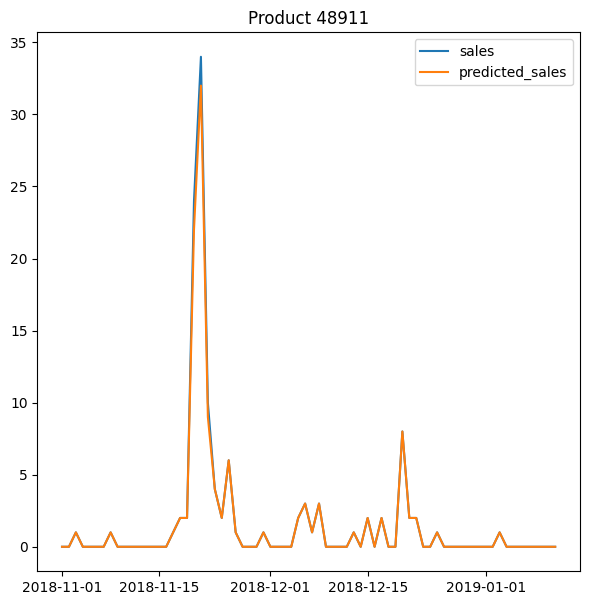

In [725]:
predict_product_sales_xgb(48911)

       productid       date  soldquantity  prediction
12477     180911 2018-11-19             0         0.0
12478     180911 2018-11-20             0         0.0
12479     180911 2018-11-21            61        64.0
12480     180911 2018-11-22            21        21.0
12481     180911 2018-11-23             8         9.0
12482     180911 2018-11-24             7         7.0
12483     180911 2018-11-25             0         0.0
12484     180911 2018-11-26             0         0.0
12485     180911 2018-11-28             3         3.0
12486     180911 2018-11-29             1         1.0
12487     180911 2018-11-30             0         0.0
12488     180911 2018-12-01             1         1.0
12489     180911 2018-12-02             0         0.0
12490     180911 2018-12-03             0         0.0
12491     180911 2018-12-05             0         0.0
12492     180911 2018-12-06             1         1.0
12493     180911 2018-12-07             0         0.0
12494     180911 2018-12-08 

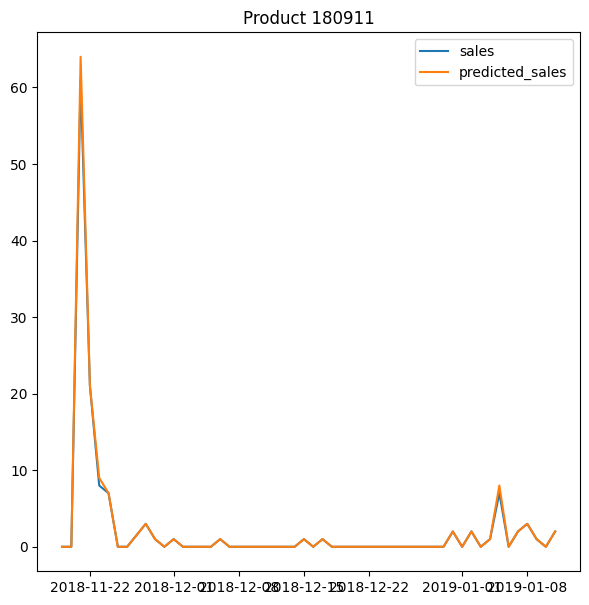

In [726]:
predict_product_sales_xgb(180911)

       productid       date  soldquantity  prediction
21432      25441 2018-11-01             9         9.0
21433      25441 2018-11-02             4         4.0
21434      25441 2018-11-03             2         2.0
21435      25441 2018-11-04             2         2.0
21436      25441 2018-11-05             5         5.0
...          ...        ...           ...         ...
21497      25441 2019-01-05             0         0.0
21498      25441 2019-01-06             0         0.0
21499      25441 2019-01-07             1         1.0
21500      25441 2019-01-08             0         0.0
21501      25441 2019-01-09             0         0.0

[70 rows x 4 columns]


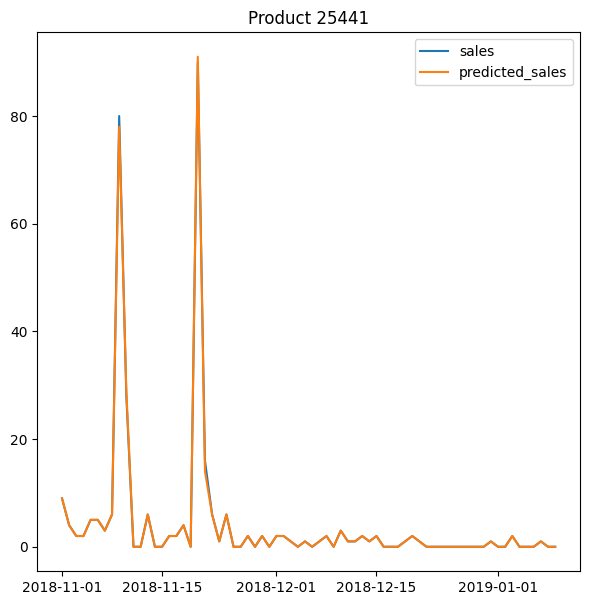

In [727]:
predict_product_sales_xgb(25441)